## Reproducing and Extending "Identifying IoT Devices and Events Based on Packet Length from Encrypted Traffic"

Authors: Mahira Ali, Murtaza Ali, Zohar Cochavi, Roland Kromes

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from sklearn import svm, neighbors, tree, ensemble, model_selection, metrics

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn import ensemble as imb_ensemble

from joblib import Parallel, delayed

sns.set_theme()
sns.axes_style("whitegrid")
sns.set_context("talk")

from IPython.core.display import HTML
_ = HTML("""
<style>
.output {
    display: flex;
    justify-content: center;
}
</style>
""")

In [93]:
from IPython.display import display_html
from itertools import chain,cycle

def display_inline(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

## Contents

1. Introduction
2. Method
    1. Dataset
    2. IoT- and Device Classifiers
    3. Simulation
3. Results
    1. Classifier Performance
    2. Impact of Padding on Classification
    3. Classification in a Real-World Scenario
4. Discussion
5. Conclusion

## 1. Introduction

- Papers
    - _Identifying IoT Devices and Events Based on Packet Length from Encrypted Traffic_ [1].
    - _Adaptive packet padding approach for smart home networks: A tradeoff between privacy and performance_ [2].

- Goals
    - Reproduce the results as found by [1] and provide an implementation.
    - Reproduce the tool used for padding as suggested by [2].
    - Verify the results as found by [2].
    - Determine the performance of the classifiers in [1] in a more realistic scenario.

## 2. Methodology

1. Dataset
    - Exploration
    - Discussing Discrepencies
    - Final Version
2. IoT- and Device Classifiers
    - Comparing to the reference implementation
    - Code Walkthrough
3. Simulation

### 2.1 Methodology | Dataset 

- Provided by the fine folks of the University of New South Wales Sydney (UNSW - Sydney) [3].
- Some unclarities regarding the use of the dataset
    - Provided CSV's don't include ICMP(v6) (and some others)
    - Not clear if [1] used all of the available data
    - 


In [58]:
data_folder = "data/traces/"

def read_date(date: str):
    """Aggregate data of a single from parts"""
    data = pd.DataFrame()

    for i in range(50):
        try:
            frame = pd.read_csv(data_folder + date + "-{}.csv".format(i))
            data = pd.concat([data, frame], axis=0)
        except OSError:
            pass

    return data


def read_date_part(date_part: str):
    """Read data of a part of a capture date"""
    data = pd.DataFrame()

    try:
        frame = pd.read_csv(data_folder + date_part + ".csv")
        data = pd.concat([data, frame], axis=0)
    except OSError:
        pass

    return data

def read_all_data():
    dates = ["16-09", "16-10", "16-11"]
    data = pd.DataFrame()

    for date in dates:
        try:
            data = pd.concat([data, read_date(date)])
        except OSError:
            pass

    return data

In [59]:
data = read_date_part("16-09-24")
data.columns = ["packet_id","timestamp","packet_size", "eth_src", "device_name" ,"protocol", "iot"]

data

,packet_id,timestamp,packet_size,eth_src,device_name,protocol,iot
0,2,1474639202852817920,156,30:8c:fb:2f:e4:b2,NaN,Raw,False
1,3,1474639203068012032,66,14:cc:20:51:33:ea,NaN,TCP,False
2,4,1474639203340540928,140,70:5a:0f:e4:9b:c0,NaN,Raw,False
3,5,1474639203540681984,66,14:cc:20:51:33:ea,NaN,TCP,False
4,7,1474639203809144064,42,14:cc:20:51:33:ea,NaN,ARP,False
...,...,...,...,...,...,...,...
752617,799228,1474725597938214912,157,08:21:ef:3b:fc:e3,NaN,Raw,False
752618,799231,1474725598502096896,156,30:8c:fb:2f:e4:b2,NaN,Raw,False
752619,799232,1474725598717321984,66,14:cc:20:51:33:ea,NaN,TCP,False
752620,799233,1474725599260491008,66,00:24:e4:11:18:a8,NaN,TCP,False


In [4]:
def filter_icmp(df: pd.DataFrame):
    return df.loc[(df['protocol'] != "ICMP") | (df['protocol'] != "ICMPv6")]

filter_icmp(data)

,packet_id,timestamp,packet_size,eth_src,device_name,protocol,iot
0,2,1474639202852817920,156,30:8c:fb:2f:e4:b2,NaN,Raw,False
1,3,1474639203068012032,66,14:cc:20:51:33:ea,NaN,TCP,False
2,4,1474639203340540928,140,70:5a:0f:e4:9b:c0,NaN,Raw,False
3,5,1474639203540681984,66,14:cc:20:51:33:ea,NaN,TCP,False
4,7,1474639203809144064,42,14:cc:20:51:33:ea,NaN,ARP,False
...,...,...,...,...,...,...,...
752617,799228,1474725597938214912,157,08:21:ef:3b:fc:e3,NaN,Raw,False
752618,799231,1474725598502096896,156,30:8c:fb:2f:e4:b2,NaN,Raw,False
752619,799232,1474725598717321984,66,14:cc:20:51:33:ea,NaN,TCP,False
752620,799233,1474725599260491008,66,00:24:e4:11:18:a8,NaN,TCP,False


In [5]:
def attach_window_id(timestamped_frame: pd.DataFrame) -> pd.DataFrame:
    first_packet_time = timestamped_frame.iloc[0]['timestamp']
    last_packet_time = timestamped_frame.iloc[-1]['timestamp']

    ns_in_sec = int(1e9)
    windows = range(first_packet_time - 1, last_packet_time + ns_in_sec, ns_in_sec)

    windowed_frame = pd.cut(timestamped_frame['timestamp'], windows, labels=range(len(windows) - 1)).to_frame()
    windowed_frame.columns = ["window_id"]
    return pd.concat([timestamped_frame, windowed_frame], axis=1).set_index('window_id')
    

windowed_frame = attach_window_id(data)

display(windowed_frame)

,packet_id,timestamp,packet_size,eth_src,device_name,protocol,iot
window_id,,,,,,,
0,2,1474639202852817920,156,30:8c:fb:2f:e4:b2,NaN,Raw,False
0,3,1474639203068012032,66,14:cc:20:51:33:ea,NaN,TCP,False
0,4,1474639203340540928,140,70:5a:0f:e4:9b:c0,NaN,Raw,False
0,5,1474639203540681984,66,14:cc:20:51:33:ea,NaN,TCP,False
0,7,1474639203809144064,42,14:cc:20:51:33:ea,NaN,ARP,False
...,...,...,...,...,...,...,...
86395,799228,1474725597938214912,157,08:21:ef:3b:fc:e3,NaN,Raw,False
86395,799231,1474725598502096896,156,30:8c:fb:2f:e4:b2,NaN,Raw,False
86395,799232,1474725598717321984,66,14:cc:20:51:33:ea,NaN,TCP,False


In [6]:
def generate_features_labeled(windowed_frame: pd.DataFrame, device_frame: pd.DataFrame, padded=False, exclude_devices=[]):
    """Calculate the mode, mean, and median of a window"""
    if padded:
        windowed_frame = pad_data(windowed_frame) 

    features = pd.DataFrame()

    for device_index in device_frame.index:
        device = device_frame.iloc[device_index]
        device_name = device['device_name']

        if device_name in exclude_devices:
            print("Excluding {}...".format(device_name))
            continue

        device_packets = windowed_frame.loc[windowed_frame['eth_src'] == device['eth_src']]
        device_features = generate_features(device_packets)

        device_features.insert(len(device_features.columns), "device_name", device_name)
        device_features.insert(len(device_features.columns), "iot", device['iot'])

        features = pd.concat([features, device_features])

    features.columns = ["mean", "std", "n_bytes", "device_name", "iot"]
    return features  

def generate_features(windowed_frame: pd.DataFrame):
    window_groups = windowed_frame.groupby("window_id", observed=True)

    mean = window_groups['packet_size'].mean()
    std = window_groups['packet_size'].std()
    n_bytes = window_groups['packet_size'].sum()

    return pd.concat([mean, std, n_bytes], axis=1).fillna(0)

def pad_data(windowed_frame, rounding=100.0):
    padded = windowed_frame.copy()
    padded['packet_size'] = padded['packet_size'].apply(lambda x: _round_to(x, rounding=rounding))
    return padded

def _round_to(value, rounding=100.0):
    return int(np.ceil(value / rounding)) * rounding  

In [7]:
devices = pd.read_csv("data/list_of_devices.csv")

labeled_features = generate_features_labeled(windowed_frame, devices)
labeled_features_padded = generate_features_labeled(windowed_frame, devices, padded=True)
labeled_features_no_cam = generate_features_labeled(windowed_frame, devices, 
                                exclude_devices=["Samsung SmartCam", "Dropcam", 
                                                 "Insteon Camera", "Nest Dropcam", 
                                                 "Withings Smart Baby Monitor", 
                                                 "TP-Link Day Night Cloud camera", 
                                                 "Netatmo Welcome"])

display(devices)
display(labeled_features)
display(labeled_features_no_cam)

Excluding Netatmo Welcome...
Excluding TP-Link Day Night Cloud camera...
Excluding Samsung SmartCam...
Excluding Dropcam...
Excluding Insteon Camera...
Excluding Withings Smart Baby Monitor...
Excluding Nest Dropcam...


,device_name,eth_src,connection_type,iot
0,Smart Things,d0:52:a8:00:67:5e,Wired,True
1,Amazon Echo,44:65:0d:56:cc:d3,Wireless,True
2,Netatmo Welcome,70:ee:50:18:34:43,Wireless,True
3,TP-Link Day Night Cloud camera,f4:f2:6d:93:51:f1,Wireless,True
4,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,True
5,Dropcam,30:8c:fb:2f:e4:b2,Wireless,True
6,Insteon Camera,00:62:6e:51:27:2e,Wired,True
7,Unknown,e8:ab:fa:19:de:4f,Wireless,False
8,Withings Smart Baby Monitor,00:24:e4:11:18:a8,Wired,True
9,Belkin Wemo switch,ec:1a:59:79:f4:89,Wireless,True


,mean,std,n_bytes,device_name,iot
window_id,,,,,
7,60.0,0.000000,60,Smart Things,True
13,60.0,0.000000,60,Smart Things,True
16,91.5,44.547727,183,Smart Things,True
26,60.0,0.000000,60,Smart Things,True
36,60.0,0.000000,60,Smart Things,True
...,...,...,...,...,...
86392,66.0,0.000000,132,TPLink Router Bridge LAN (Gateway),False
86393,60.0,8.485281,120,TPLink Router Bridge LAN (Gateway),False
86394,54.0,16.970563,108,TPLink Router Bridge LAN (Gateway),False


,mean,std,n_bytes,device_name,iot
window_id,,,,,
7,60.0,0.000000,60,Smart Things,True
13,60.0,0.000000,60,Smart Things,True
16,91.5,44.547727,183,Smart Things,True
26,60.0,0.000000,60,Smart Things,True
36,60.0,0.000000,60,Smart Things,True
...,...,...,...,...,...
86392,66.0,0.000000,132,TPLink Router Bridge LAN (Gateway),False
86393,60.0,8.485281,120,TPLink Router Bridge LAN (Gateway),False
86394,54.0,16.970563,108,TPLink Router Bridge LAN (Gateway),False


### 2.2 Methodoly | IoT- and Device Classifiers

- Using general-purpose classifiers:
    - k-NN
    - Decision Tree (DT)
    - Random Forest (RF)
    - ~Support Vector Machine (SVM)~
    - Majority Voting (MV)
- Exact parameters and testing methodology unclear
- Balancing data to improve performance
    - IoT Classifier
        - Oversampling (Synthetic Minority Oversampling TEchnique, SMOTE)
        - Undersampling (Random Under-Sampling, RUS)
        - ~Ensemble Balanced Trainer~
    - Device Classifier
        - Stratified KFold

In [8]:
def _get_models():
    models = {
        "k-NN" : neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance"),
        "DT"  : tree.DecisionTreeClassifier(),
        "RF"  : ensemble.RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),
        # "SVM" : svm.SVC(),
    }
    params = {
        "k-NN" : 
            {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 40], 'weights' : ["distance", "uniform"]},
        "DT" : {'max_depth' : [None, 5, 8, 10] ,'min_samples_split' : [2, 3, 4, 5]},
        "RF" : { 'n_estimators' : [1, 2, 3, 4, 5, 7, 10], 'max_depth' : [None, 5, 8, 10] ,'min_samples_split' : [2, 3, 4, 5] },
        # "SVM" : {},
    }
    # I don't really see the advantage of using an ensemble balancing method in conjuction with the
    # under- and oversample techniques. I can't find any indication in the paper the referenced [32]
    # that it actually works. So, I'm just keeping this here.
    models["Majority Voting"] = ensemble.VotingClassifier(list(models.items()))
    params["Majority Voting"] = {'voting' : ['hard', 'soft']}

    return models, params

In [9]:
from enum import StrEnum

class Balancing(StrEnum):
    NONE = "none"
    STRATIFIED = "stratified"
    OVER_UNDER = "over_under"
    OVER_UNDER_RUS = "over_under_rus"
    OVER = "over"
    UNDER = "under"
    UNDER_RUS = "under_rus"

def _balance_over_under(X, y, rus=False, random_state: int | None = None, undersample=True, oversample=True):
    oversampling = SMOTE(random_state=random_state)

    # Resource [32] is actually really old (2009), NearMiss is a better alternative than RUS
    # but I left it as an option
    if rus:
        undersampling = RandomUnderSampler(random_state=random_state)
    else:
        undersampling = NearMiss()

    if oversample:
        X, y = oversampling.fit_resample(X, y)
    if undersample:
        X, y = undersampling.fit_resample(X, y)

    return X, y

def _using_kfold(n_splits):
    return n_splits > 1

def _trained_model_name(scores):
    return "{}_{}_{}".format(scores["model"][-1], scores["label"][-1], scores["balancing"][-1])

def _evaluate(model_name: str, measurement: str, value: float, target_label: str, balancing: Balancing, scores={}):
    if len(scores.keys()) == 0:
        scores = {"model" : [], "measurement" : [], "value" : [], "label" : [], "balancing" : []}

    scores["model"].append(model_name)
    scores["measurement"].append(measurement)
    scores["value"].append(value)
    scores["label"].append(target_label)
    scores["balancing"].append(balancing)

    return scores

def _specificity(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)

    num_classes = cm.shape[0]
    specificity = []

    for i in range(num_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm, i, axis=0)[:, i])

        if tn + fp == 0.0:
            specificity.append(0.0)
        else:
            specificity.append(tn / (tn + fp))
    
    return sum(specificity) / len(specificity)

def _geometric_mean(*scores):
    return np.prod(scores) ** (1.0/len(scores))

def _evaluate_model(model, X_test, y_test, model_name, target_label: str, balancing: Balancing, scores={}):
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    specificity = _specificity(y_test, predictions)

    # As we have quite a number of devices, there is chance that some class in y_test is not in the predictions.
    # In this case, the precision and recall cannot be calculated as there are no positives (either true, or false)
    # which results in a zero dvisions error. In our case, this means that the classifier has misclassified something,
    # and we 'punish' it by returning zero. This should occur less as the test size increases
    precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, predictions, average='macro', zero_division=0.0)
    geo_mean = _geometric_mean(accuracy, precision, recall, fscore, specificity)

    scores = _evaluate(model_name, "accuracy", accuracy, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "recall", recall, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "fscore", fscore, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "precision", precision, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "specificity", specificity, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "geo_mean", geo_mean, target_label, balancing, scores=scores)

    return scores

def _custom_tuner(X_train, y_train, models_and_params=None, balancing=Balancing.NONE, target_label=None, n_splits=10, n_jobs=-1):
    if n_splits < 2:
        print("Cannot use hyper parameter tuning with less than 2 splits. Defaulting to 10.")
        n_splits = 10
    if balancing == Balancing.STRATIFIED:
        print("Warning: Stratified balancing with hyper parameter tuning is effectively Balancing.NONE")
    
    models, params = _get_models() if models_and_params is None else models_and_params
    scores = {}
    trained = {}

    for (name, model) in models.items():
        # hardcoded, but I can't think of a 'nicer' solution atm
        if name == "Majority Voting":
            model = ensemble.VotingClassifier(list(trained.items())) 

        tuning = model_selection.GridSearchCV(
                model, 
                params[name], 
                scoring = ["f1_macro"], 
                refit="f1_macro",
                cv=n_splits,
                n_jobs=n_jobs
            )
        tuning.fit(X_train, y_train)

        scores = _evaluate(name, "fscore", tuning.best_score_, target_label=target_label, balancing=balancing, scores=scores)
        trained[name] = tuning.best_estimator_

    return trained, pd.DataFrame(scores)

def _train_model(model, X_train, X_test, y_train, y_test, target_label, balancing):
    trained_model = model[1].fit(X_train, y_train)
    scores = _evaluate_model(trained_model, X_test, y_test, model_name=model[0], target_label=target_label, balancing=balancing)

    return (model[0], trained_model), scores


def _custom_kfold(X_train, y_train, models_and_params=None, target_label=None, balancing=Balancing.NONE, kf=None, parallelize=False):
    models, _ = _get_models() if models_and_params is None else models_and_params
    scores = None
    trained = {}

    if kf is not None:
        folds = [ (X_train.iloc[train], X_train.iloc[test], y_train.iloc[train], y_train.iloc[test]) for (train, test) in kf.split(X_train, y_train) ]
    else:
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train, y_train, test_size=.25)
        folds = [ (X_train, X_test, y_train, y_test) ]
    
    out = []

    if parallelize:
        out = Parallel(n_jobs=len(models.keys()), verbose=0, pre_dispatch='1.5*n_jobs')(
            delayed(_train_model)(model, X_train, X_test, y_train, y_test, target_label, balancing) 
            for model in models.items() 
            for (X_train, X_test, y_train, y_test) in folds
        )
    else: 
        for model in models.items():
            for (X_train, X_test, y_train, y_test) in folds:
                out.append(_train_model(model, X_train, X_test, y_train, y_test, target_label, balancing))

    for (model_name, trained_model), score in out:
        trained[model_name] = trained_model

        if scores is None:
            scores = score
        else:
            for (key, values) in score.items():
                scores[key] += values

    return trained, pd.DataFrame(scores)

In [10]:
class Trainer():
    def __init__(self, labeled_features, target_label, balancing=Balancing.NONE, 
                 random_state=42, n_splits=10, shuffle=False, test_size=.1, 
                 eval_size=.25, with_tuning=False) -> None:
        self.balancing = balancing 
        self.target_label = target_label
        self.with_tuning = with_tuning

        self.models, self._hyper_params = _get_models()
        self._params = None
        self.trained_models = None

        self._random_state = random_state
        self._shuffle = shuffle
        self._n_splits = n_splits

        self._init_kf()
        self._init_data(labeled_features)

        print("Initialized {} trainer on {} datapoints with {} features and {} labels".format(target_label, len(labeled_features[target_label]), len(self.unbalanced[0].columns), len(labeled_features[target_label].unique())))

    def _init_data(self, labeled_features):
        X_bal = labeled_features.iloc[:, 0:3]
        y_bal = labeled_features.iloc[:][self.target_label]

        self.unbalanced = (X_bal, None, y_bal, None)

        X_bal, X_ubal, y_bal, y_ubal = model_selection.train_test_split(X_bal, y_bal, test_size=.1)
        self.balanced =  (X_bal, X_ubal, y_bal, y_ubal)

        
        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=self._random_state, oversample=True, undersample=False)
        self.over = (X_bal, X_ubal, y_bal, y_ubal)
        
        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=self._random_state, oversample=False, undersample=True)
        self.under = (X_bal, X_ubal, y_bal, y_ubal)

        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=self._random_state, oversample=False, undersample=True, rus=True)
        self.under_rus = (X_bal, X_ubal, y_bal, y_ubal)

        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=self._random_state)
        self.over_under = (X_bal, X_ubal, y_bal, y_ubal)

        X_bal, y_bal = _balance_over_under(X_bal, y_bal, rus=True, random_state=self._random_state)
        self.over_under_rus = (X_bal, X_ubal, y_bal, y_ubal)

    def _init_kf(self):
        random_state = self._random_state if self.shuffle else None

        self.kf_strat = model_selection.StratifiedKFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=random_state) if self.using_kfold else None
        self.kf = model_selection.KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=random_state) if self.using_kfold else None
        
    @property
    def params(self):
        return self._params

    @params.setter
    def params(self, params):
        self._params = params
        
        for (name, model) in self.models.items():
            model.set_params(**self._params[name])
    
    @property
    def n_splits(self):
        return self._n_splits
    
    @n_splits.setter
    def n_splits(self, n_splits):
        self._n_splits = n_splits
        self._init_kf()
        return self

    @property
    def shuffle(self):
        return self._shuffle

    @shuffle.setter
    def shuffle(self, shuffle):
        self._shuffle = shuffle
        self._init_kf()
        return self

    @property
    def using_kfold(self):
        return self.n_splits > 1
   
    def train_models(self, balancing=None, with_tuning=None, parallelize=True):
        if balancing is None:
            balancing = self.balancing
        if with_tuning is None:
            with_tuning = self.with_tuning

        assert not (balancing == Balancing.STRATIFIED and not self.using_kfold)

        data = self._data(balancing)
        kf = self.kf

        if balancing == Balancing.STRATIFIED:
            data = self.balanced
            kf = self.kf_strat

        X_train, X_test, y_train, y_test = data
        print("Training {} classifier with balancing: '{}' and {} folds".format(
            self.target_label, balancing, 
            self.n_splits if self.using_kfold else "without", 
            "(parallelized)" if parallelize else ""))

        if with_tuning and self.params is None:
            self.tune() 

        trained, scores_bal = _custom_kfold(X_train, y_train, models_and_params=(self.models, self.params), 
                                            kf=kf, balancing=balancing, target_label=self.target_label, 
                                            parallelize=parallelize) 

        # If we haven't done balancing, the scores are good as they are
        if balancing == Balancing.NONE:
            return trained, scores_bal

        # Otherwise, we should test on the unbalanced datasets
        self.trained_models = trained
        scores_ubal = self.test(X_test, y_test, balancing=balancing)

        return trained, scores_ubal

    def test(self, X_test, y_test, trained=None, balancing=None):
        if balancing is None:
            balancing = self.balancing
        if trained is None:
            trained = self.trained_models

        scores = {}
        for (name, model) in trained.items():
            scores = _evaluate_model(model, X_test, y_test, 
                                        name, target_label=self.target_label, 
                                        balancing=balancing, scores=scores)

        return pd.DataFrame(scores)


    def tune(self):
        data = self._data()

        X_train, _, y_train, _ = data
        print("Optimizing {} trainer with balancing: '{}' and {} folds {}".format(
            self.target_label, self.balancing, self.n_splits if self.using_kfold else "10 (default)"))

        trained, scores = _custom_tuner(X_train, y_train, models_and_params=(self.models, self._hyper_params), 
                                            n_splits=self.n_splits, balancing=self.balancing, target_label=self.target_label)
        params = {}

        for (name, model) in trained.items():
            params[name] = model.get_params()

        self.params = params
        return params, scores

        
    def _data(self, balancing):
        data = self.unbalanced
        
        if balancing == Balancing.OVER:
            data = self.over
        if balancing == Balancing.UNDER:
            data = self.under
        if balancing == Balancing.UNDER_RUS:
            data = self.under_rus
        if balancing == Balancing.OVER_UNDER:
            data = self.over_under
        if balancing == Balancing.OVER_UNDER_RUS:
            data = self.over_under_rus

        return data

class IotTrainer(Trainer):
    def __init__(self, labeled_features) -> None:
        super().__init__(labeled_features, target_label='iot', n_splits=1, balancing=Balancing.OVER)

class DeviceTrainer(Trainer):
    def __init__(self, iot_features) -> None:
        super().__init__(iot_features, target_label='device_name', n_splits=10, balancing=Balancing.STRATIFIED) 

In [11]:
device_labeled_features = labeled_features.loc[labeled_features['iot'] == True]

iot_trainer = IotTrainer(labeled_features)
device_trainer = DeviceTrainer(device_labeled_features)

Initialized iot trainer on 254168 datapoints with 3 features and 2 labels
Initialized device_name trainer on 168711 datapoints with 3 features and 15 labels


## 2.3 Methodology | Simulation

## 3 Results

1. Classifier Performance
2. Impact of Padding on Classification
3. Classification in a Real-World Scenario

- We'll discuss the results immediately as well

### 3.1 Results | Classifier Performance

In [12]:
def _parse_experiments(experiments):
    trained_classifiers = [ experiment[0] for experiment in experiments ]
    all_scores = pd.concat([ experiment[1] for experiment in experiments ])

    return trained_classifiers, all_scores

In [13]:
def run_iot_experiments(trainer: Trainer| None = None, labeled_features: pd.DataFrame | None = None):
    if trainer is None:
        assert labeled_features is not None
        trainer = IotTrainer(labeled_features)

    experiments = [
        trainer.train_models(balancing=Balancing.OVER), 
        trainer.train_models(balancing=Balancing.UNDER_RUS),
    ]

    return _parse_experiments(experiments)

def run_device_experiments(trainer: Trainer| None = None, labeled_features: pd.DataFrame | None = None):
    if trainer is None:
        assert labeled_features is not None

        device_features = labeled_features.loc[labeled_features['iot'] == True]
        trainer = DeviceTrainer(device_features)

    experiments = [
        trainer.train_models(balancing=Balancing.STRATIFIED),
    ]

    return _parse_experiments(experiments)

def run_all_experiments(iot_trainer=None, device_trainer=None, labeled_features=None):
    iot_models, iot_scores = run_iot_experiments(trainer=iot_trainer, labeled_features=labeled_features)
    device_models, device_scores = run_device_experiments(trainer=device_trainer, labeled_features=labeled_features)

    return iot_models + device_models, pd.concat([iot_scores, device_scores])

In [14]:
_, all_scores = run_all_experiments(iot_trainer=iot_trainer, device_trainer=device_trainer)

all_scores.groupby(['label', 'balancing', 'measurement', 'model']).mean()

Training iot classifier with balancing: 'over' and without folds
Training iot classifier with balancing: 'under_rus' and without folds
Training device_name classifier with balancing: 'stratified' and 10 folds


value
label       balancing  measurement model                    
device_name stratified accuracy    DT               0.862079
                                   Majority Voting  0.862731
                                   RF               0.862672
                                   k-NN             0.850699
                       fscore      DT               0.629547
...                                                      ...
iot         under_rus  recall      k-NN             0.882148
                       specificity DT               0.898095
                                   Majority Voting  0.899146
                                   RF               0.898907
                                   k-NN             0.882148

[72 rows x 1 columns]

In [36]:
def draw_graph(scores, device=False):
    plot = sns.catplot(scores, x="measurement", y="value", hue="model", col="balancing", kind="bar")
    plot.set_ylabels("")
    plot.set_xlabels("")
    plot.set_titles("{col_name}")
    plot.tick_params(axis='x', rotation=45)

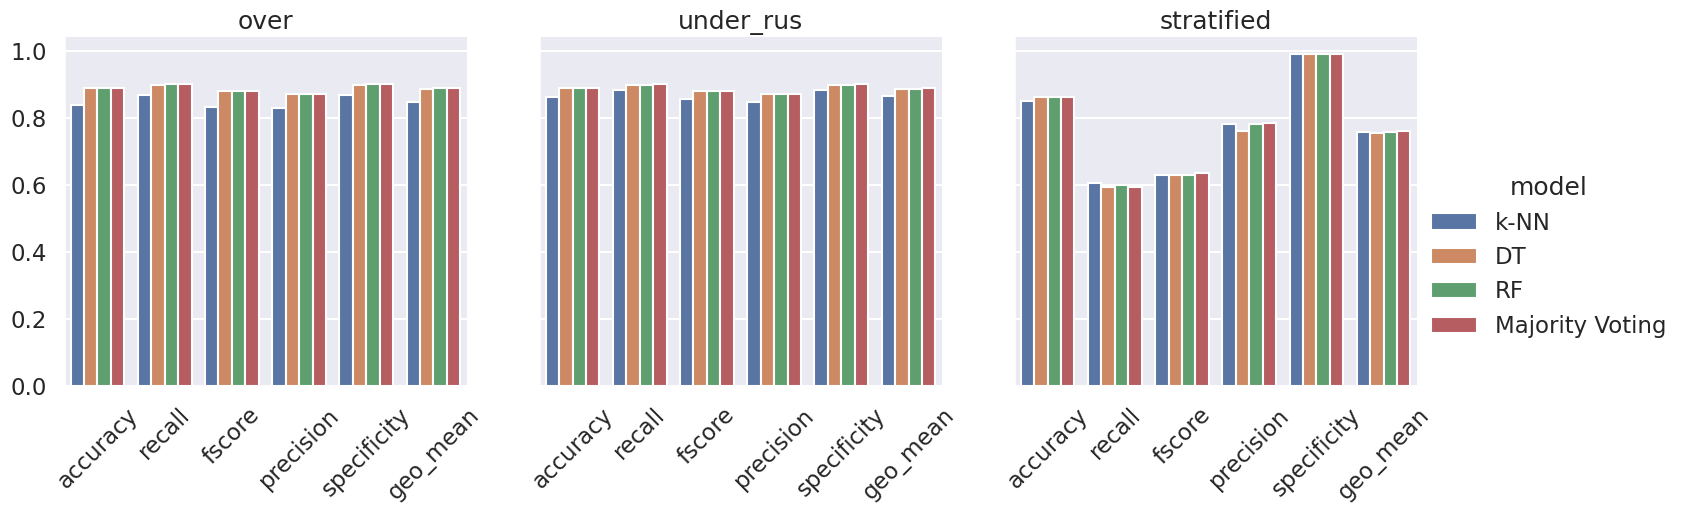

In [46]:
draw_graph(all_scores)

- Good results for the IoT classifier (especially for not running hyper parameter tuning!)
- The device classifier is working less well
- big a disparity between the accuracy and recall/fscore

In [51]:
_, all_scores_no_cam =  run_all_experiments(labeled_features=labeled_features_no_cam)

all_scores_no_cam.groupby(['label', 'balancing', 'measurement', 'model']).mean()

Initialized iot trainer on 139291 datapoints with 3 features and 2 labels
Training iot classifier with balancing: 'over' and without folds
Training iot classifier with balancing: 'under_rus' and without folds
Initialized device_name trainer on 53834 datapoints with 3 features and 10 labels
Training device_name classifier with balancing: 'stratified' and 10 folds


value
label       balancing  measurement model                    
device_name stratified accuracy    DT               0.859027
                                   Majority Voting  0.859584
                                   RF               0.859212
                                   k-NN             0.842311
                       fscore      DT               0.671863
...                                                      ...
iot         under_rus  recall      k-NN             0.920906
                       specificity DT               0.926516
                                   Majority Voting  0.926792
                                   RF               0.926985
                                   k-NN             0.920906

[72 rows x 1 columns]

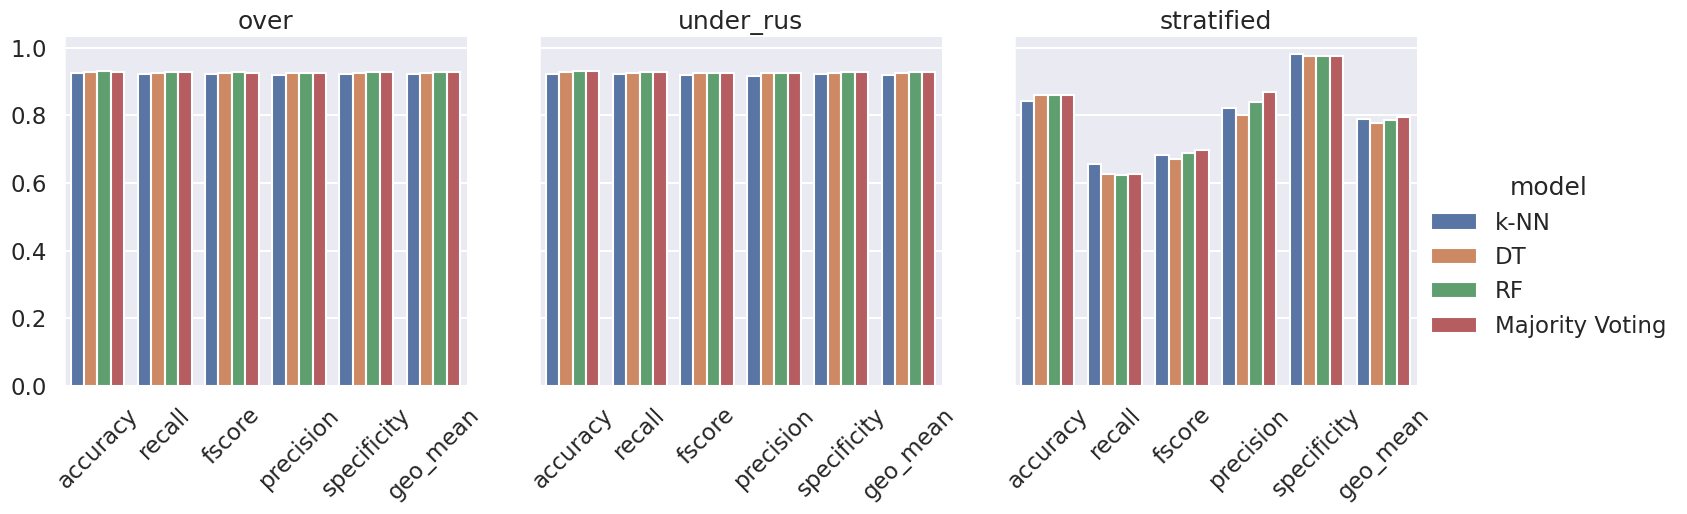

In [52]:
draw_graph(all_scores_no_cam)

- Better performance for the IoT classifier
    - Makes sense as cameras transfer fairly large files
- Device classifier is not really impacted

In [76]:
iot_over = {'Metric': ['Precision', 'Precision', 'Recall', 'Recall', 'F1-score', 'F1-score', 'Specificity', 'Specificity', 'Geometric mean', 'Geometric mean',],
        'Method': ['Reproduced', 'Original', 'Reproduced', 'Original', 'Reproduced', 'Original', 'Reproduced', 'Original', 'Reproduced', 'Original',],
        'k-NN': [86, 95, 88, 95, 87, 95, 88, 97, 88, 96],
        'RF': [88, 97, 89, 97, 88, 97, 89, 98, 89, 97],
        'DT': [88, 96, 89, 96, 88, 96, 89, 98, 88, 97],
        'MV': [88, 95, 89, 95, 88, 95, 89, 97, 89, 96]}

device_strat = {'Metric': ['Accuracy', 'Accuracy', 'Recall', 'Recall', 'F1-score', 'F1-score ', 'Specificity', 'Specificity', 'Geometric mean', 'Geometric mean'],
        'Method': ['Reproduced', 'Original', 'Reproduced', 'Original', 'Reproduced', 'Original', 'Reproduced', 'Original', 'Reproduced', 'Original'],
        'k-NN': [82, 92, 59, 92, 63, 92, 99, 99, 75, 95],
        'RF': [84, 94, 63, 94, 65, 94, 99, 99, 77, 96],
        'DT': [84, 94, 63, 94, 65, 94, 99, 99, 77, 96],
        'MV': [84, 94, 63, 94, 65, 94, 99, 99, 76, 96]
       }

df_iot_over = pd.DataFrame(iot_over).set_index("Metric")
df_device_strat = pd.DataFrame(device_strat).set_index("Metric")


In [96]:
display_inline(df_iot_over, df_device_strat, 
               titles=["IoT classifier with over-sampling", "Device classifier with stratified balancing"])

,Method,k-NN,RF,DT,MV
Metric,,,,,
Precision,Reproduced,86,88,88,88
Precision,Original,95,97,96,95
Recall,Reproduced,88,89,89,89
Recall,Original,95,97,96,95
F1-score,Reproduced,87,88,88,88
F1-score,Original,95,97,96,95
Specificity,Reproduced,88,89,89,89
Specificity,Original,97,98,98,97
Geometric mean,Reproduced,88,89,88,89


- Results are similar
- Device classifier performance is rather weak compared to reference
- Similar results for the dataset without a camera

### 3.2 Results | Impact of Padding on Classification


- The idea is to 'obscure' the characterizing traffic
- Different levels of padding are possible
- But no free lunch

In [97]:
def test_padding(trainer: Trainer, padded_features, draw_graph=False):
    X_test = padded_features.iloc[:, 0:3]
    y_test = padded_features[:][trainer.target_label]

    return trainer.test(X_test, y_test)

device_features_padded = labeled_features_padded.loc[labeled_features['iot'] == True]

device_padded_results = test_padding(device_trainer, device_features_padded)
iot_padded_results = test_padding(iot_trainer, labeled_features_padded)

all_padded_results = pd.concat([device_padded_results, iot_padded_results])

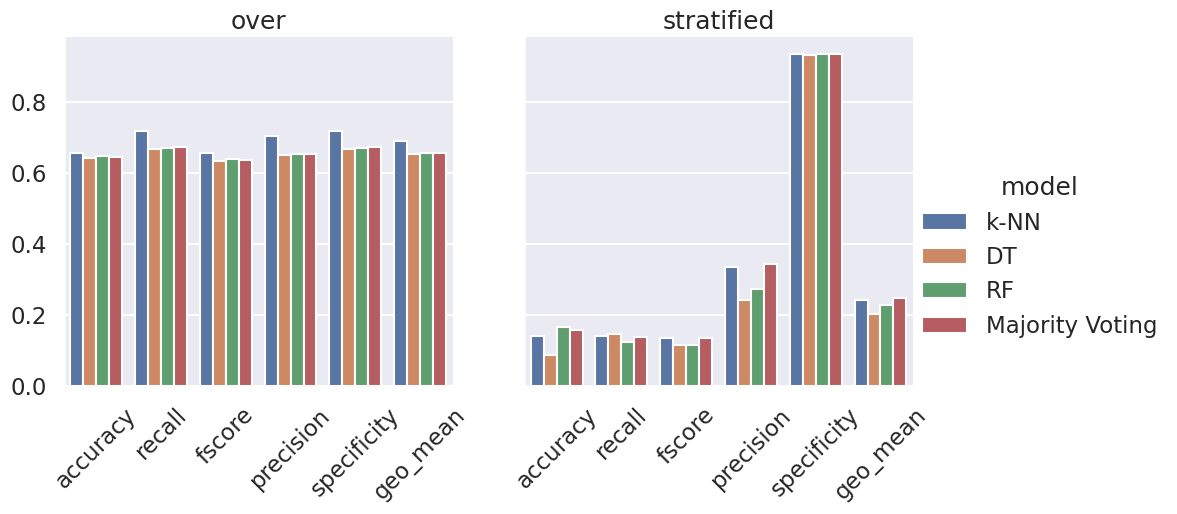

In [45]:
draw_graph(all_scores_padded)

- Device classifier performing as expected (around 60% decrease overall)
- Specificity might not be a very good metric for high numbers of classes
- IoT classifier is not that impacted

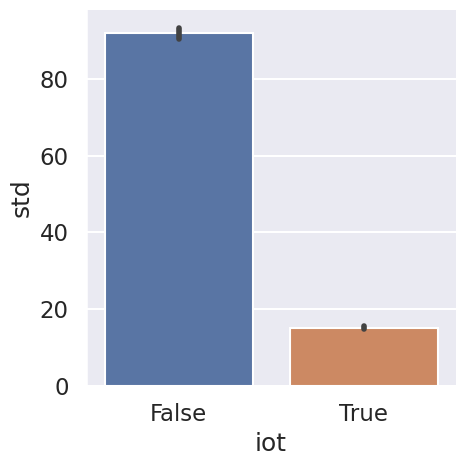

In [99]:
_ = sns.catplot(labeled_features_padded, y="std", x="iot", kind="bar")

- Padding with $m=100$ (i.e. round to the nearest 100) not adequate
- Privacy at the cost of bandwith

## References

[1] Antônio J Pinheiro, Jeandro de M Bezerra, Caio AP Burgardt, and Divanilson R
Campelo. 2019. Identifying IoT devices and events based on packet length from
encrypted traffic. _Computer Communications_ 144 (2019), 8–17

[2] Antônio J Pinheiro, Paulo Freitas de Araujo-Filho, Jeandro de M Bezerra, and
Divanilson R Campelo. 2020. Adaptive packet padding approach for smart home
networks: A tradeoff between privacy and performance. _IEEE Internet of Things
Journal_ 8, 5 (2020), 3930–3938.

[3]
